[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Arabas_et_al_2023/aida.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Arabas_et_al_2023/aida.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Arabas_et_al_2023/aida.ipynb)

inspired by Fig. 2 in [Steinke et al. 2011](https://doi.org/10.5194/acp-11-12945-2011) ("Ice nucleation properties of fine ash particles from the Eyjafjallajokull eruption in April 2010")

## package imports

In [8]:
import math
import numpy as np

from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

from PySDM import Builder, Formulae
from PySDM.backends import CPU
from PySDM.environments import Parcel
from PySDM.dynamics import AmbientThermodynamics, Condensation, Freezing
from PySDM.physics import si
from PySDM import products as PySDM_products
from PySDM.initialisation.sampling import spectral_sampling
from PySDM.initialisation.spectra import Lognormal
from PySDM.initialisation import equilibrate_wet_radii

from PySDM_examples.utils import BasicSimulation

## parameter values

In [2]:
vertical_velocity = 5 * si.m / si.s
aerosol_cloud_radius_threshold = .25 * si.um
dNdD = Lognormal(200 / si.cm**3, m_mode=0.4 * si.um, s_geom=1.8)
common = {
    'n_sd': int(1e4),  # number of super-particles / moving-bins
    'dt': 1 * si.s,  # timestep
    'p0': 1000 * si.hPa,  # initial pressure
    'T0': 253 * si.K, # initial temperature
    'initial_water_vapour_mixing_ratio': .58 * si.g/si.kg,
    't_max': 300 * si.s,
    'volume': 84.5 * si.m**3,
    'kappa': .1,  # hygroscopicity
    'formulae': Formulae(
        particle_shape_and_density="MixedPhaseSpheres",
        saturation_vapour_pressure='MurphyKoop2005',
        heterogeneous_ice_nucleation_rate='ABIFM',
        freezing_temperature_spectrum='Niemand_et_al_2012',
        constants = {
            # time-dependent model parameters
            'ABIFM_M': 28.13797,
            'ABIFM_C': -2.92414,
            # singular model parameters
            'NIEMAND_A': -0.517,
            'NIEMAND_B': 8.934
        }
    )
}

## class definitions to adapt PySDM building blocks for AIDA case study

In [3]:
class AIDA(Parcel):
    """ a kludge to mimick departures from adiabaticy (like wall losses?) """
    def get_thd(self):
        self['thd'][:] += .5e-2 * si.K / si.min / si.kg * self.particulator.dt * self.mass_of_dry_air
        return self['thd']

    def get_water_vapour_mixing_ratio(self):
        self['water_vapour_mixing_ratio'][:] += .1e-3 * si.g / si.min / si.kg * self.particulator.dt * self.mass_of_dry_air
        return self['water_vapour_mixing_ratio']

In [4]:
class Settings:  # pylint: disable=too-many-instance-attributes,too-few-public-methods
    """ container class for simulation parameters """
    def __init__(self, *, n_sd, dt, t_max, p0, T0, initial_water_vapour_mixing_ratio, attributes, formulae, volume, kappa, singular):
        dry_air_density = formulae.trivia.p_d(p0, initial_water_vapour_mixing_ratio) / formulae.constants.Rd / T0

        self.n_sd = n_sd
        self.dt = dt
        self.t_max = t_max
        self.p0 = p0
        self.T0 = T0
        self.initial_water_vapour_mixing_ratio = initial_water_vapour_mixing_ratio
        self.attributes = attributes
        self.formulae = formulae
        self.kappa = kappa
        self.singular = singular
        self.mass_of_dry_air = dry_air_density * volume

In [5]:
class Simulation(BasicSimulation):  # pylint: disable=too-few-public-methods
    """ orchestrates AIDA-like simulation setup and run """
    def __init__(self, settings: Settings):
        self.settings = settings
        env = AIDA(
            dt = settings.dt,
            mass_of_dry_air = settings.mass_of_dry_air,
            p0 = settings.p0,
            T0 = settings.T0,
            initial_water_vapour_mixing_ratio = settings.initial_water_vapour_mixing_ratio,
            w = vertical_velocity,
            mixed_phase = True
        )
        builder = Builder(n_sd=settings.n_sd, backend=CPU(settings.formulae), environment=env)
        builder.add_dynamic(AmbientThermodynamics())
        builder.add_dynamic(Condensation())
        builder.add_dynamic(Freezing(singular=settings.singular))

        dry_radius = settings.formulae.trivia.radius(volume=settings.attributes['dry volume'])
        self._set_attribute(
            settings.attributes,
            'kappa times dry volume',
            settings.kappa * settings.attributes['dry volume']
        )
        self._set_attribute(
            settings.attributes,
            'volume',
            settings.formulae.trivia.volume(
                radius=equilibrate_wet_radii(
                    r_dry=dry_radius,
                    environment=env,
                    kappa_times_dry_volume=settings.attributes['kappa times dry volume'] 
                )
            )
        )
        if settings.singular:
            self._set_attribute(
                settings.attributes,
                'freezing temperature',
                settings.formulae.freezing_temperature_spectrum.invcdf(
                    np.random.random(settings.n_sd),
                    settings.formulae.trivia.sphere_surface(diameter=dry_radius * 2)
                )
            )
        else:
            self._set_attribute(
                settings.attributes,
                'immersed surface area',
                settings.formulae.trivia.sphere_surface(diameter=dry_radius * 2)
            )
        
        super().__init__(builder.build(
            settings.attributes,
            products=(
                PySDM_products.AmbientPressure(var='p', unit='hPa'),
                PySDM_products.AmbientTemperature(var='T'),
                PySDM_products.AmbientRelativeHumidity(var='RH', unit='%'),
                PySDM_products.AmbientRelativeHumidity(var='RH', name='RHi', ice=True, unit='%'),
                PySDM_products.ParticleConcentration(
                    name='n_a', unit='1/cm**3',
                    radius_range=(0, np.inf)),
                PySDM_products.ParticleConcentration(
                    name='n_c', unit='1/cm**3',
                    radius_range=(aerosol_cloud_radius_threshold, np.inf)),
                PySDM_products.ParticleConcentration(
                    name='n_i', unit='1/cm**3',
                    radius_range=(-np.inf, 0)),
                PySDM_products.EffectiveRadius(
                    name='r_eff', unit='um',
                    radius_range=(aerosol_cloud_radius_threshold, np.inf)),
                PySDM_products.Time()
            )
        ))
        
    @staticmethod
    def _set_attribute(attributes, attr, value):
        assert attr not in attributes
        attributes[attr] = value
        
    def run(self):
        return super()._run(
            nt = math.ceil(self.settings.t_max / self.settings.dt),
            steps_per_output_interval=1
        )

## execution of simulations

In [6]:
d_dry, conc = spectral_sampling.ConstantMultiplicity(dNdD).sample(common['n_sd'])

ATTRIBUTES = {
    'n': conc * common['volume'],
    'dry volume': common['formulae'].trivia.volume(radius=d_dry / 2)
}

outputs = []
SETTINGS = [
    Settings(**common, attributes=dict(ATTRIBUTES), singular=False),
    Settings(**common, attributes=dict(ATTRIBUTES), singular=True),
]
for setting in SETTINGS:
    simulation = Simulation(setting)
    outputs.append(simulation.run())

## plotting

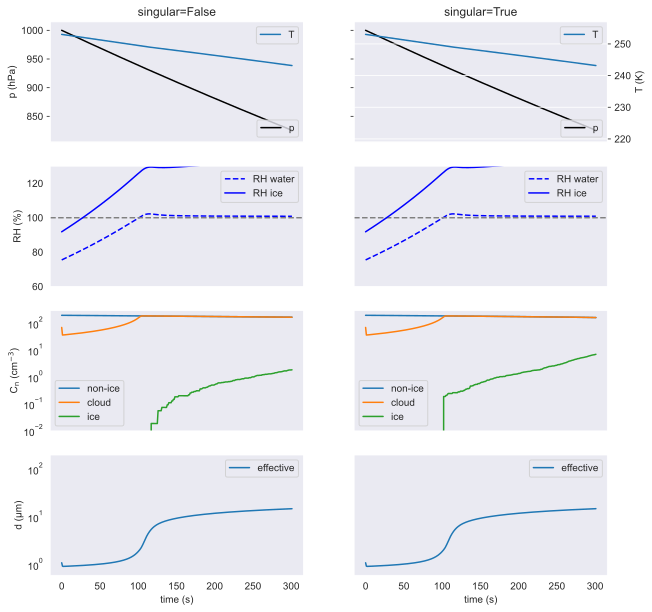

HTML(value="<a href='./fig_2.pdf' target='_blank'>./fig_2.pdf</a><br>")

In [7]:
fig, axs = pyplot.subplots(4, 2, figsize=(10, 10), sharex=True)
for i, output in enumerate(outputs):
    axT = axs[0, i]
    axT.set_title(f"singular={SETTINGS[i].singular}")
    axT.grid()
    axT.set_ylim(805, 1015)
    axT.plot(output['time'], output['ambient pressure'], color='black', label='p')
    twin = axT.twinx()
    twin.plot(output['time'], output['ambient temperature'], label='T')
    twin.set_ylim(219, 257)
    axT.legend(loc='lower right')
    twin.legend(loc='upper right')
    if i == 1:
        twin.set_ylabel('T (K)')
        pyplot.setp(axT.get_yticklabels(), visible=False)
    else:
        axT.set_ylabel('p (hPa)')
        twin.get_yaxis().set_visible(False)
    
    axRH = axs[1, i]
    axRH.set_ylim(60, 130)
    axRH.grid()
    axRH.plot(
        output['time'],
        output['ambient relative humidity'], linestyle='--', color='blue',
        label='RH water'
    )
    axRH.axhline(100, linestyle='--', color='gray')
    axRH.plot(output['time'], output['RHi'], color='blue', label='RH ice')
    axRH.legend()
    if i == 0:
        axRH.set_ylabel('RH (%)')
    else:
        pyplot.setp(axRH.get_yticklabels(), visible=False)
      
    axC = axs[2, i]
    axC.grid()
    axC.set_yscale('log')
    axC.set_ylim(.01, 300)
    axC.plot(output['time'], output['n_a'], label='non-ice')
    axC.plot(output['time'], output['n_c'], label='cloud')
    axC.plot(output['time'], output['n_i'], label='ice')
    axC.legend()
    if i == 0:
        axC.set_ylabel(r'C$_{\rm n}$ (cm$^{-3}$)')
    else:
        pyplot.setp(axC.get_yticklabels(), visible=False)
        
    axd = axs[3, i]
    axd.grid()
    axd.plot(output['time'], 2*np.asarray(output['r_eff']), label='effective')
    axd.set_xlabel('time (s)')
    axd.set_yscale('log')
    axd.set_ylim(.6, 200)
    axd.legend()
    if i == 0:
        axd.set_ylabel('d (μm)')
    else:
        pyplot.setp(axd.get_yticklabels(), visible=False)
        
        
show_plot('fig_2.pdf')